# AirBnb listings file modeling - final regressions

This file loads the cleaned data, runs it through the pipeline and runs the regressors on the data with all the hyperparameters tuned and ready.  

In [40]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import warnings
import ast
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [41]:
import os
import seaborn as sns
import pandas as pd
import math

import sklearn.model_selection as cv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE

from imblearn.over_sampling import SMOTE

from Utils.UtilsViz import *
from Utils.DataUtils import *

RANDOM_SEED = 42

In [42]:
sns.set(font_scale=2, style="whitegrid")

In [43]:
data_path = os.path.join(os.getcwd(), "../data/cleaned_listings.csv")
listings = pd.read_csv(data_path, index_col="id")
display(listings.shape)

(48855, 65)

### Plot the dstribution

Let's plot the percentile for price

Text(0, 0.5, 'Price')

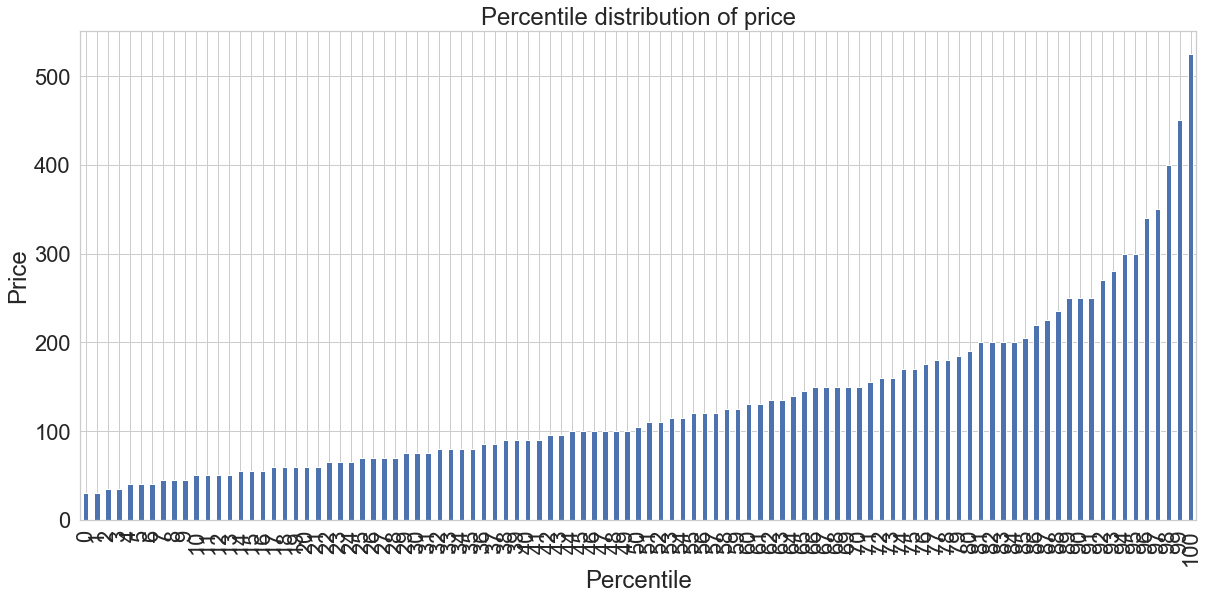

In [44]:
percentiles = list(range(0,101, 1))
price_percentile = {}
for p in percentiles:
    price_percentile[p] = np.percentile(listings['price'].values, p)

price_percentile = pd.DataFrame.from_dict(price_percentile, orient='index')
price_percentile.plot(kind='bar', figsize=(20,9), grid=True, legend=False)
plt.title("Percentile distribution of price")
plt.xlabel("Percentile")
plt.ylabel("Price")

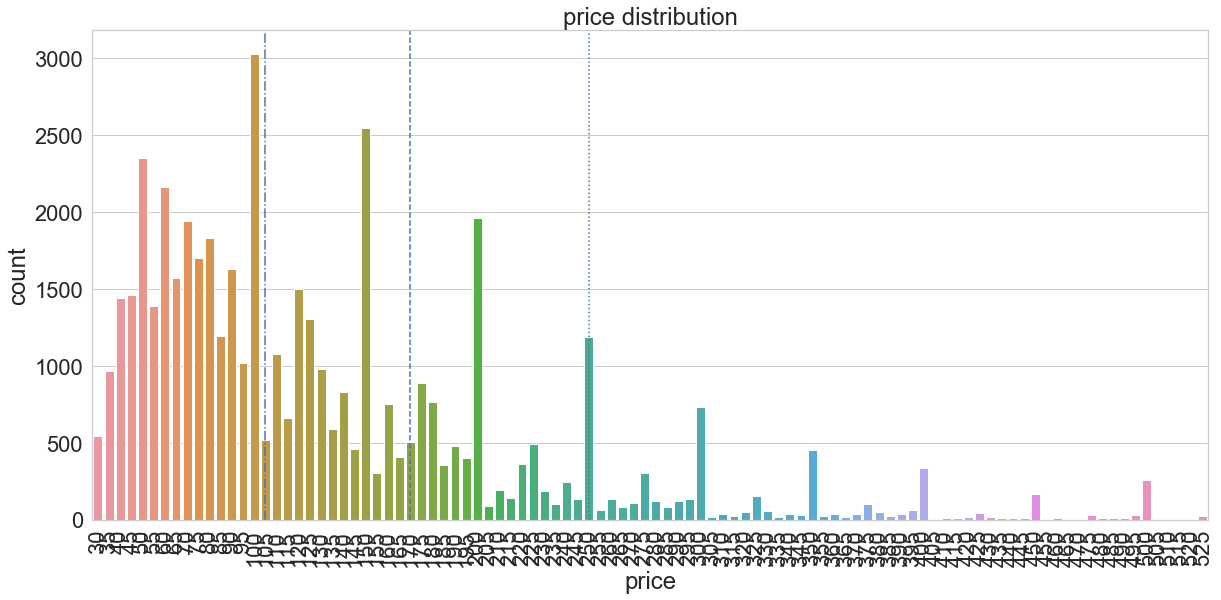

In [45]:
f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.countplot(x="price", data=listings, ax=ax)
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("price distribution")
median_idx = np.where(np.sort(listings["price"].unique())==listings["price"].median())
plt.axvline(x=median_idx, linestyle="-.")
percentile_75_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[75,:].values[0])
plt.axvline(x=percentile_75_idx, linestyle="--")
percentile_90_idx = np.where(np.sort(listings["price"].unique())==price_percentile.iloc[90,:].values[0])
plt.axvline(x=percentile_90_idx, linestyle=":")

------------------

Quick helper functions

In [46]:
def roundto(row, base=5):
    return int(base * round(float(row) / base))

# Get the index of the price columns
def get_index(vallist, val):
    return vallist.index(val)

## Oversampling using SMOTE

In [47]:
def check_rep(row):
    if (row <= 200) | (row==250) | (row==350) | (row==450) | (row==550) :
        return 0
    elif (row > 200) & (row < 300) & (row != 250):
        return 1 
    elif (row > 300) & (row < 400) & (row != 350):
        return 2 
    else:
        return 3 

listings["flag_ur"] = listings["price"].apply(check_rep)

In [48]:
vcs = listings["flag_ur"].value_counts()
vcs

0    43321
1     3093
3     1624
2      817
Name: flag_ur, dtype: int64

In [49]:
ycol = ["flag_ur"]
xcol = [i for i in listings.columns if i not in ycol]

x = listings[xcol].values
y = listings[ycol].values

smote_sampling_strategy = {
    1: int(vcs[1]*2)
    ,2: int(vcs[2]*2)
    ,3: int(vcs[3]*2)
}
sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=smote_sampling_strategy, n_jobs=-1)
# Fit the smote onto the sample
x_new, y_new = sm.fit_sample(x, y)

# Drop the flag column
listings.drop(labels=["flag_ur"], axis=1, inplace=True)

# ---------------------------------------------------------------------------------------------------------
# Overwrite X and Y
price_index = get_index(list(listings.columns), "price")

y = x_new[:, price_index]
x = np.delete(x_new, price_index, axis=1)
for i in range(len(y)):
    y[i] = roundto(y[i])

In [50]:
print(
    " Old size :", listings.shape, "\n",
    "New size :", x.shape
)

 Old size : (48855, 65) 
 New size : (54389, 64)


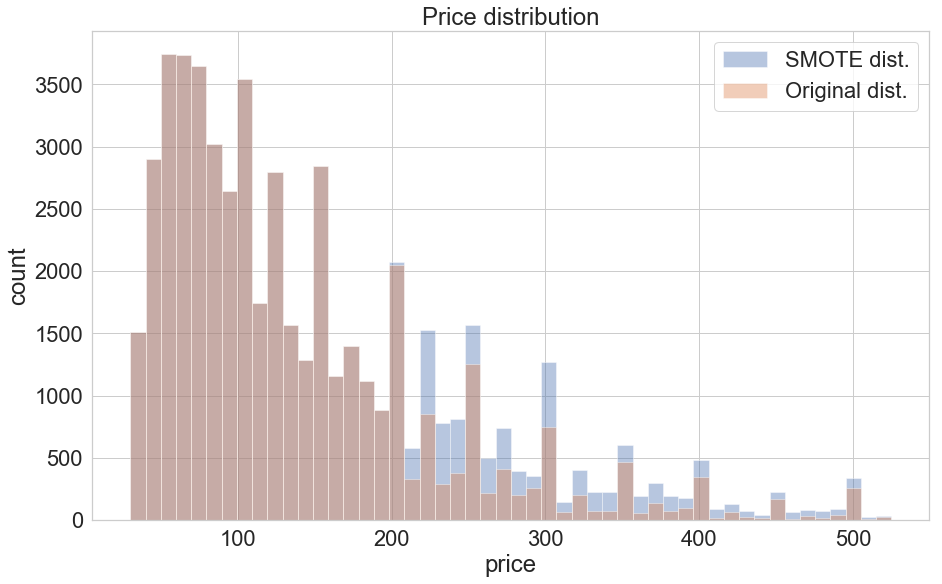

In [51]:
f, ax = plt.subplots(1, 1, figsize=(15, 9), sharey=True)
g2 = sns.distplot(y, ax=ax, kde=False, label="SMOTE dist.")
g1 = sns.distplot(listings["price"], ax=ax, kde=False, label="Original dist.")
t = g1.set(title="Price distribution", ylabel="count")
plt.legend()

In [52]:
x_cols = listings.drop(['price'], axis=1)
X = pd.DataFrame(data=x, columns=x_cols.columns)

## Train test split

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=RANDOM_SEED)

## Standardisation

In [54]:
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

## Prediction

In [55]:
# Quick placeholder variable
rmse_dict = {}
rmse_m_dict = {}

### a. Ridge Regression

In [73]:
rid = Ridge(alpha=1e-08)
rid.fit(X=x_train, y=y_train)
y_pred_train = rid.predict(X=x_train)
y_pred_test = rid.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_dict["Ridge"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 64.40
Test set RMSE Scaled: 65.17


What would be the RMSE for the majority (80 percentile) of the data?

In [74]:
th = price_percentile.iloc[80, :].values[0]

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_m_dict["Ridge"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 47.92
Test set RMSE Scaled: 49.45


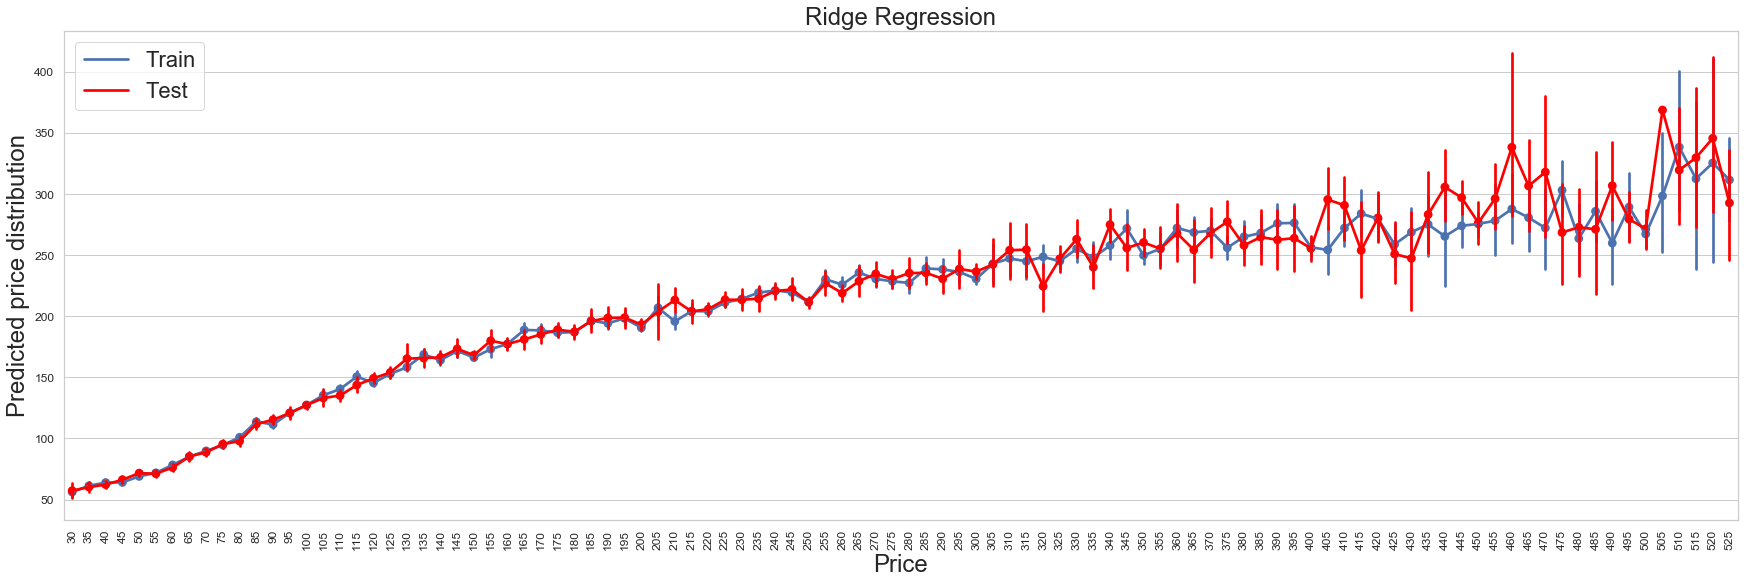

In [75]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train.astype(int), y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test.astype(int), y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Ridge Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])
t = g.tick_params(labelsize=12)


In [76]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(rid, x_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=6)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 64.53


### b. Lasso Regression

In [77]:
las = Lasso(alpha=0.15)
las.fit(X=x_train, y=y_train)
y_pred_train = las.predict(X=x_train)
y_pred_test = las.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_dict["lasso"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 64.46
Test set RMSE Scaled: 64.26


What would be the RMSE for the majority (80 percentile) of the data?

In [78]:
th = price_percentile.iloc[80, :].values[0]

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_m_dict["lasso"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 47.75
Test set RMSE Scaled: 47.50


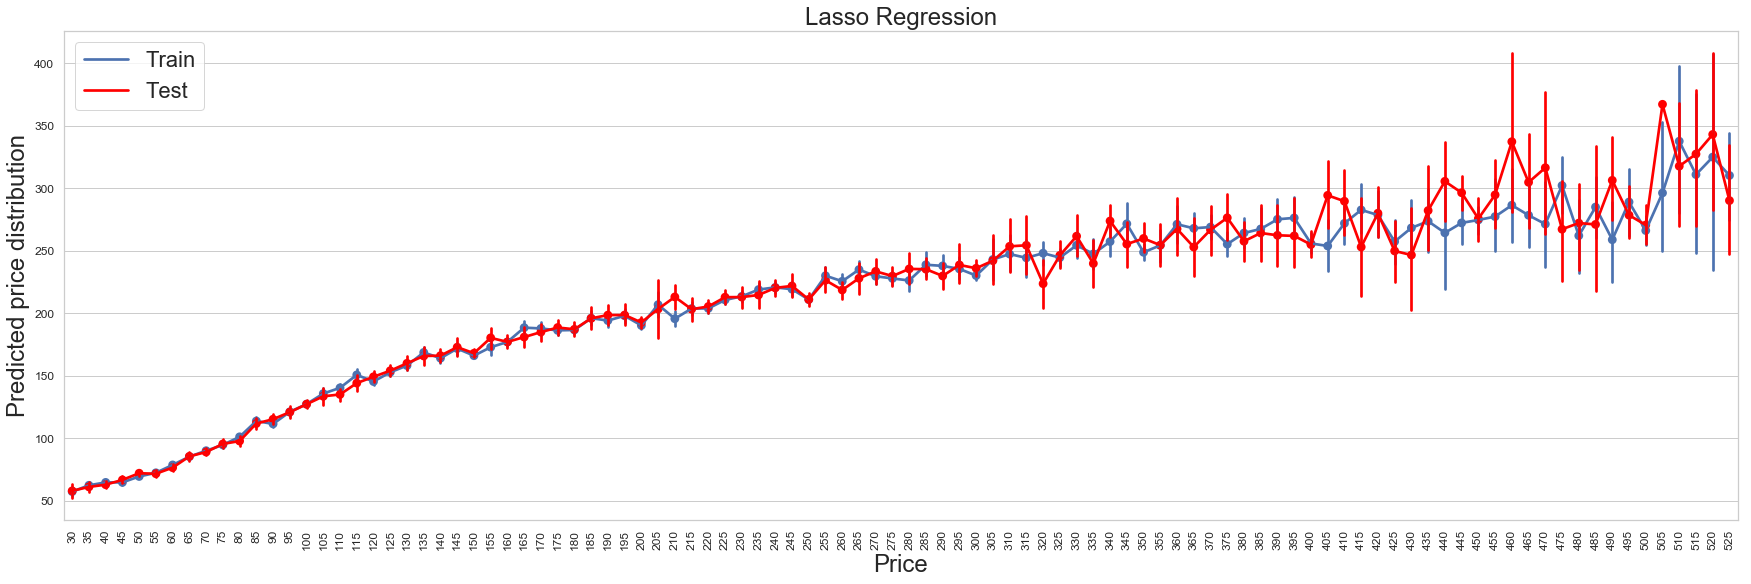

In [79]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train.astype(int), y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test.astype(int), y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Lasso Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])
t = g.tick_params(labelsize=12)


In [80]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(las, x_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=6)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 64.58


### c. Decision Trees

In [81]:
dtr = DecisionTreeRegressor(random_state=RANDOM_SEED,max_depth=14,max_features=50,min_samples_leaf=0.001142,min_samples_split=0.01)
dtr.fit(X=x_train, y=y_train)
y_pred_train = dtr.predict(X=x_train)
y_pred_test = dtr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_dict["dt"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 58.78
Test set RMSE Scaled: 59.99


What would be the RMSE for the majority (80 percentile) of the data?

In [82]:
th = price_percentile.iloc[80, :].values[0]

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_m_dict["dt"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 40.82
Test set RMSE Scaled: 41.32


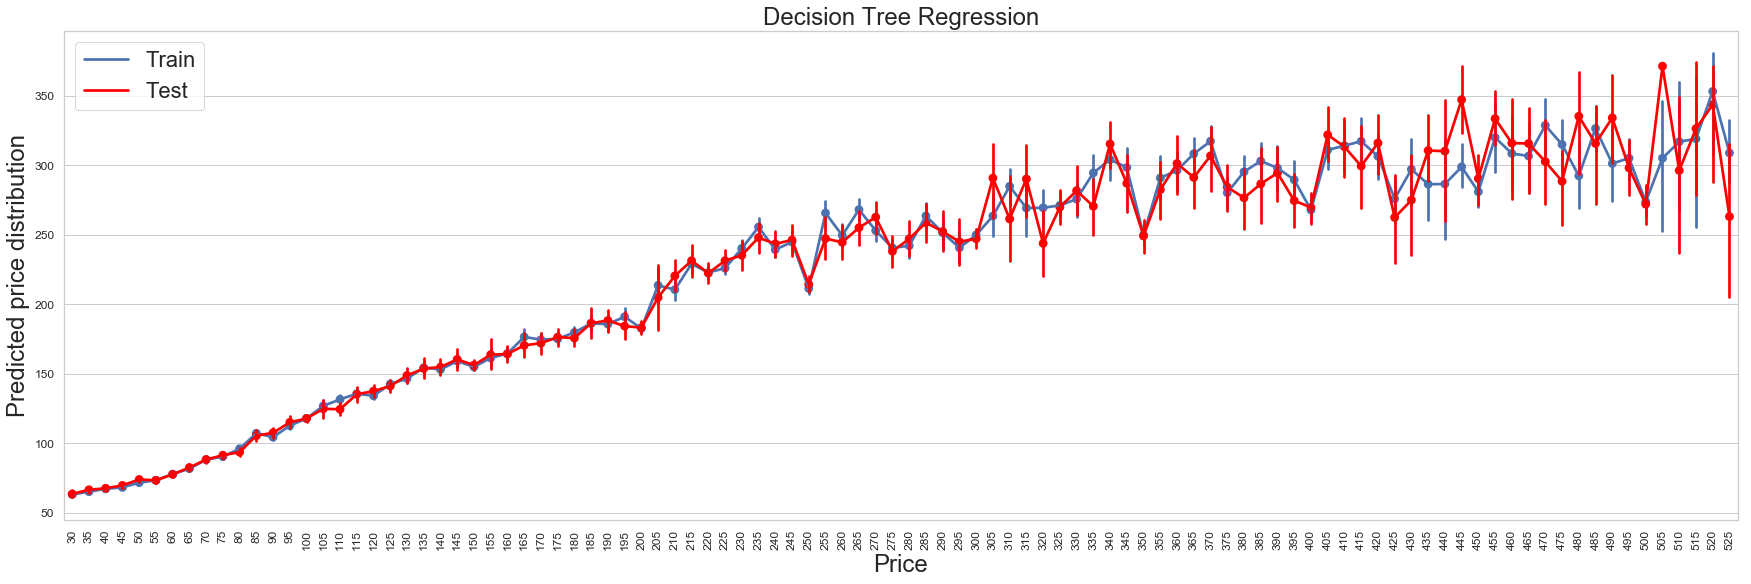

In [83]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train.astype(int), y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test.astype(int), y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Decision Tree Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])
t = g.tick_params(labelsize=12)


In [85]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(dtr, x_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=6)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 61.04


### d. Random Forests

In [86]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, bootstrap=False, criterion='mse',
                           max_depth=20, max_features='sqrt', min_samples_split=5,
                           n_estimators=400)
rfr.fit(X=x_train, y=y_train)
y_pred_train = rfr.predict(X=x_train)
y_pred_test = rfr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_dict["rf"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 22.40
Test set RMSE Scaled: 52.83


What would be the RMSE for values less than 250$?

In [87]:
th = price_percentile.iloc[80, :].values[0]

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_m_dict["rf"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 17.18
Test set RMSE Scaled: 36.84


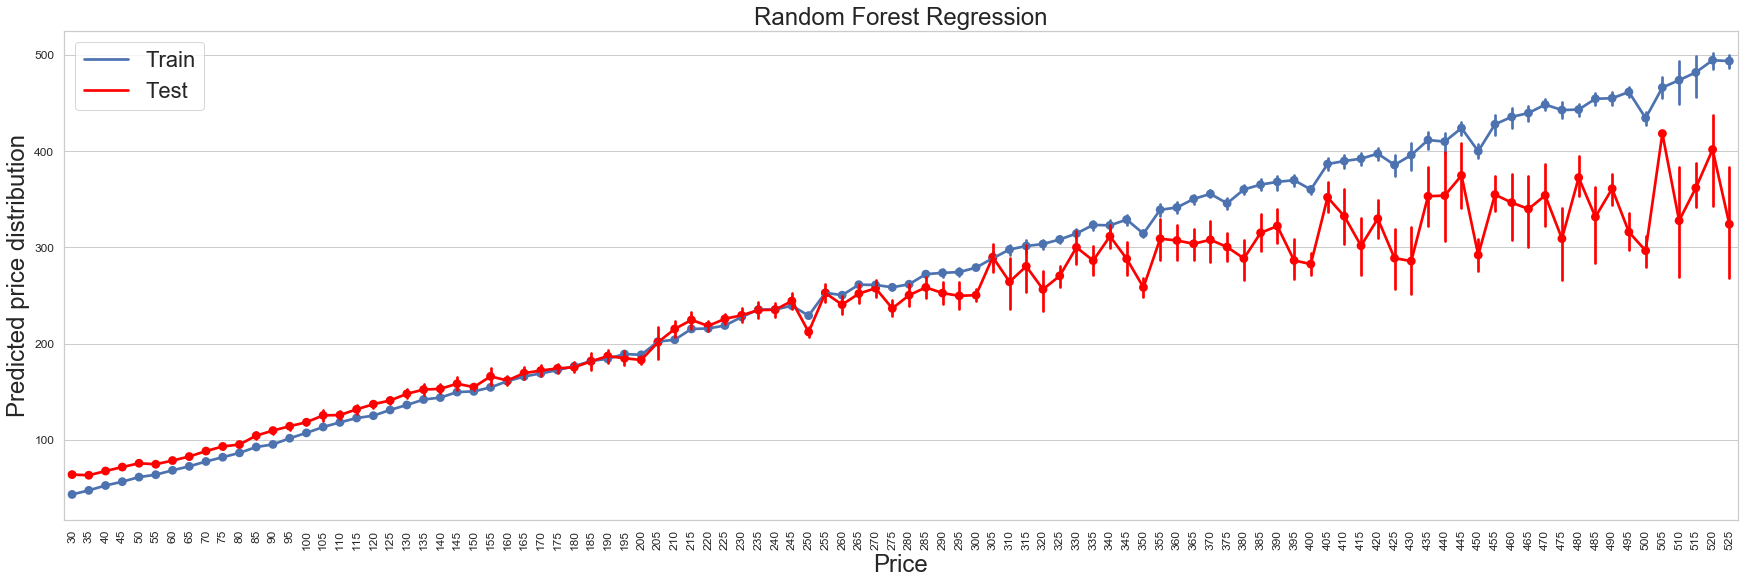

In [88]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train.astype(int), y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test.astype(int), y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Random Forest Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])
t = g.tick_params(labelsize=12)


In [89]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(rfr, x_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=6)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 53.17


#### Feature importance

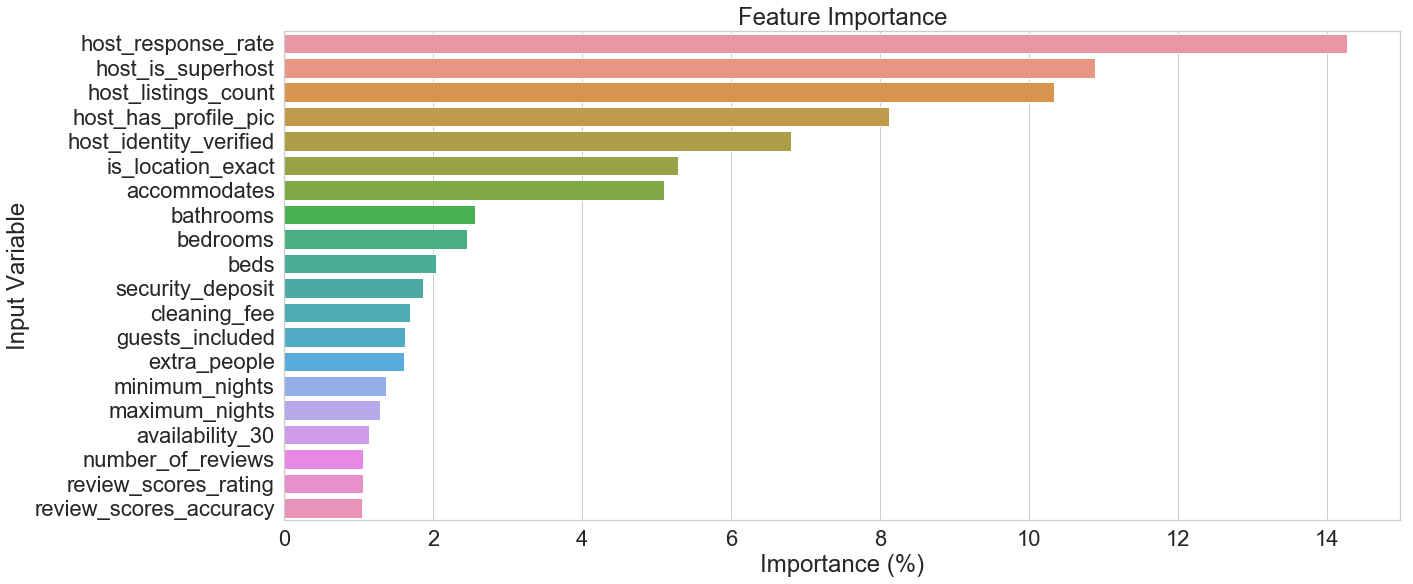

In [90]:
x_final = listings.drop(['price'], axis=1)

imp = pd.DataFrame({'Input Variable': x_final.columns, 'Importance (%)': -np.sort(-100*rfr.feature_importances_)})
top20 = imp.iloc[:20,:]

f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.barplot(x="Importance (%)", y="Input Variable", data=top20, ax=ax)
t = g.set_xlabel("Importance (%)")
t = g.set_ylabel("Input Variable")
t = g.set_title("Feature Importance")

### e. Gradient Boosting regression

In [91]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                n_estimators=400,
                                subsample=1,
                                criterion="mse",
                                max_depth=5,
                                max_features="sqrt",
                                min_samples_split=35,
                                min_samples_leaf=5,
                                learning_rate=0.1)
gbr.fit(X=x_train, y=y_train)
y_pred_train = gbr.predict(X=x_train)
y_pred_test = gbr.predict(X=x_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_dict["gbr"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 46.30
Test set RMSE Scaled: 53.15


What would be the RMSE for values less than 250$?

In [92]:
th = price_percentile.iloc[80, :].values[0]

tmpdf = pd.DataFrame({"y_train":y_train, "y_pred_train":y_pred_train})
tmpdf = tmpdf[tmpdf["y_train"] <= th]

tmpdf2 = pd.DataFrame({"y_test":y_test, "y_pred_test":y_pred_test})
tmpdf2 = tmpdf2[tmpdf2["y_test"] <= th]

mse_train = MSE(tmpdf["y_train"].values, tmpdf["y_pred_train"].values)
mse_test = MSE(tmpdf2["y_test"].values, tmpdf2["y_pred_test"].values)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

rmse_m_dict["gbr"] = {"Train":rmse_train,"Test":rmse_test}

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

Train set RMSE Scaled: 33.64
Test set RMSE Scaled: 37.08


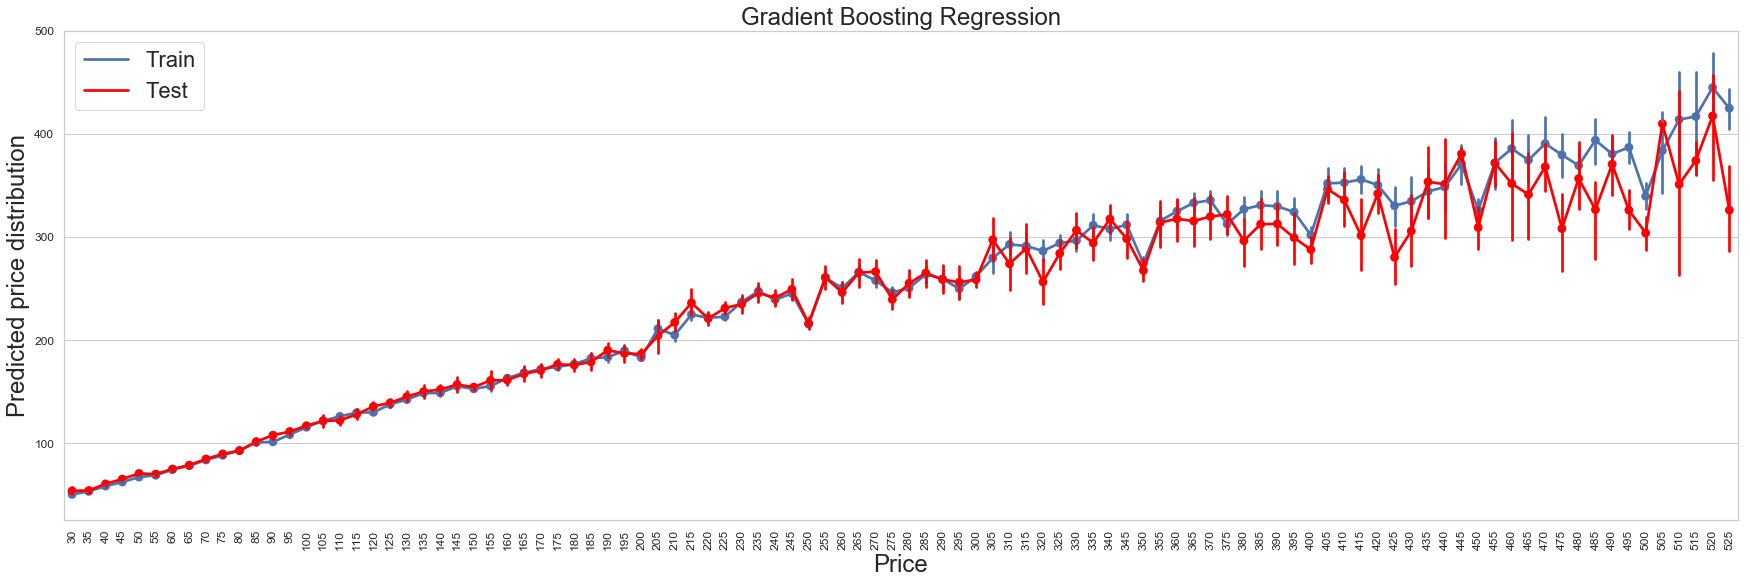

In [93]:
f, ax = plt.subplots(1,1, figsize=(30, 9), sharex=False)
g = sns.pointplot(x=y_train.astype(int), y=y_pred_train, ax=ax)
g = sns.pointplot(x=y_test.astype(int), y=y_pred_test, ax=ax, color="red")
t = g.set_xlabel("Price")
t = g.set_ylabel("Predicted price distribution")
t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Gradient Boosting Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Train","Test"])
t = g.tick_params(labelsize=12)


#### Feature importance

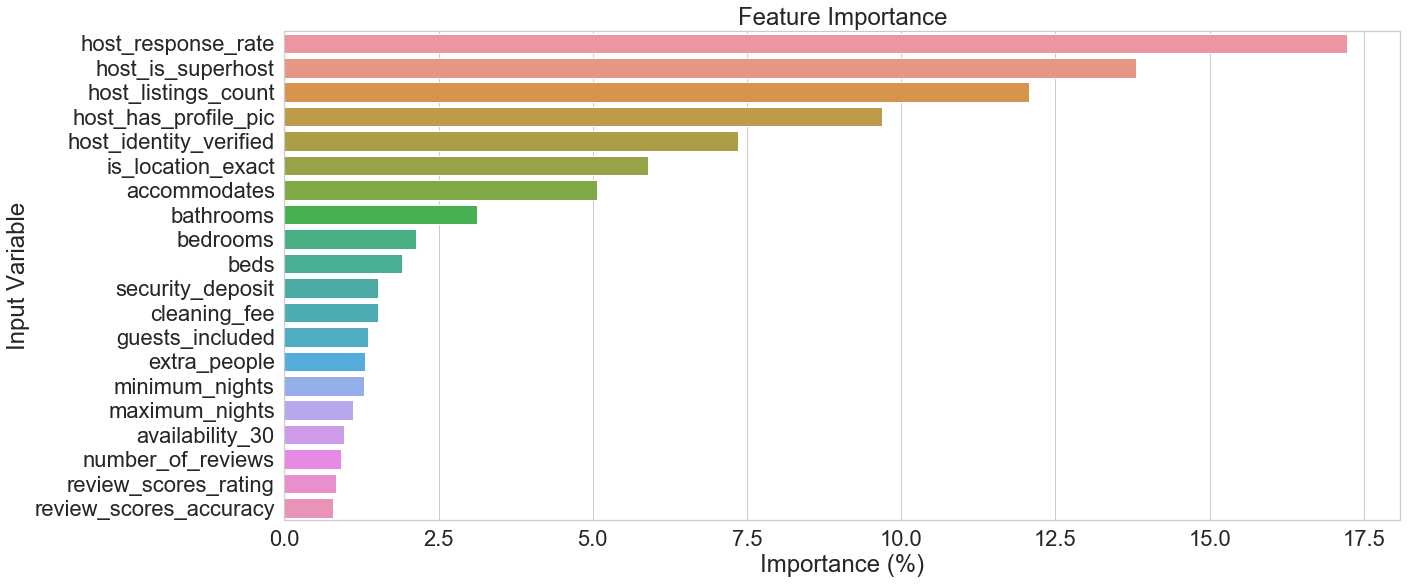

In [94]:
x_final = listings.drop(['price'], axis=1)

imp = pd.DataFrame({'Input Variable': x_final.columns, 'Importance (%)': -np.sort(-100*gbr.feature_importances_)})
top20 = imp.iloc[:20,:]

f, ax = plt.subplots(1,1,figsize=(20,9))
g = sns.barplot(x="Importance (%)", y="Input Variable", data=top20, ax=ax)
t = g.set_xlabel("Importance (%)")
t = g.set_ylabel("Input Variable")
t = g.set_title("Feature Importance")

In [95]:
# Use cross-validation on Train data

CV_scores = - cv.cross_val_score(gbr, x_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=6)

# Compute the 10-folds CV
CV = CV_scores.mean()**(1/2)

# Print Train CV accuracy
print('Cross Validation RMSE: {:.2f}'.format(CV))

Cross Validation RMSE: 52.94


----------------

Let's plot a quick bar chart that captures all this information

In [96]:
rmse_df = pd.DataFrame(rmse_dict)
rmse_df = rmse_df.T.reset_index(drop=False)
rmse_df.columns = ["Regressor", "Test RMSE", "Train RMSE"]
rmse_df

,Regressor,Test RMSE,Train RMSE
0,Ridge,65.168006,64.395215
1,lasso,64.256259,64.462710
2,dt,59.988126,58.779791
3,rf,52.831975,22.402276
4,gbr,53.151973,46.301878


In [97]:
rmse_m_df = pd.DataFrame(rmse_m_dict)
rmse_m_df = rmse_m_df.T.reset_index(drop=False)
rmse_m_df.columns = ["Regressor", "Test RMSE", "Train RMSE"]
rmse_m_df

,Regressor,Test RMSE,Train RMSE
0,Ridge,49.447526,47.920813
1,lasso,47.503708,47.751292
2,dt,41.324700,40.822763
3,rf,36.838510,17.179769
4,gbr,37.078385,33.636091


In [98]:
def plot_bar(data, x, y, ax, hue=None, title="", xlabel="", ylabel="",
             xrot=0, yrot=0, highlight_max_min=True,
             plot_percentiles=[], plot_mean=True,
             point_plot=False, annot=True, legend=False):    
    if highlight_max_min:
        clrs = []
        for v in data[y].values:
            if v < data[y].max():
                if v > data[y].min():
                    clrs.append('lightblue')
                else:
                    clrs.append('lightgreen')
            else:
                clrs.append('darksalmon')
        g = sns.barplot(x=x, y=y, data=data, ax=ax, palette=clrs)
    else:
        g = sns.barplot(x=x, y=y, data=data, ax=ax, hue=hue)
        
    if len(plot_percentiles) > 0:
        for p in plot_percentiles:
            v = np.percentile(data[y].values, p)
            plt.axhline(v, 1, 0, color='grey').set_linestyle("--")
            
    if plot_mean:
        v = data[y].mean()
        plt.axhline(v, 1, 0, color='k').set_linestyle("--")
        
    if point_plot:
        g1 = sns.pointplot(x=x, y=y, data=data, ax=ax, color="darkblue")
    if xrot != 0:
        g.set_xticklabels(rotation=xrot, labels=g.get_xticklabels())
    if yrot != 0:
        g.set_yticklabels(rotation=yrot, labels=g.get_yticklabels())
    if annot:
        # Add labels to the plot
        style = dict(size=12, color='darkblue')
        s1 = data[y].values
        counter = 0
        for idx, row in data.iterrows():
            rx, ry = row[x], row[y]
            if type('str') == type(idx):
                ax.text(counter, ry, str(np.round(ry, 2)), 
                    **style, va="bottom", ha='right')
            else:
                ax.text(idx*0.99, ry, str(np.round(s1[idx], 2)), 
                        **style, va="bottom", ha='right')
            counter += 1
    g.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_ylim([0, data[y].max() * 1.2])
    if legend:
        ax.legend(handles=ax.lines[::len(data) + 1], labels=[y])


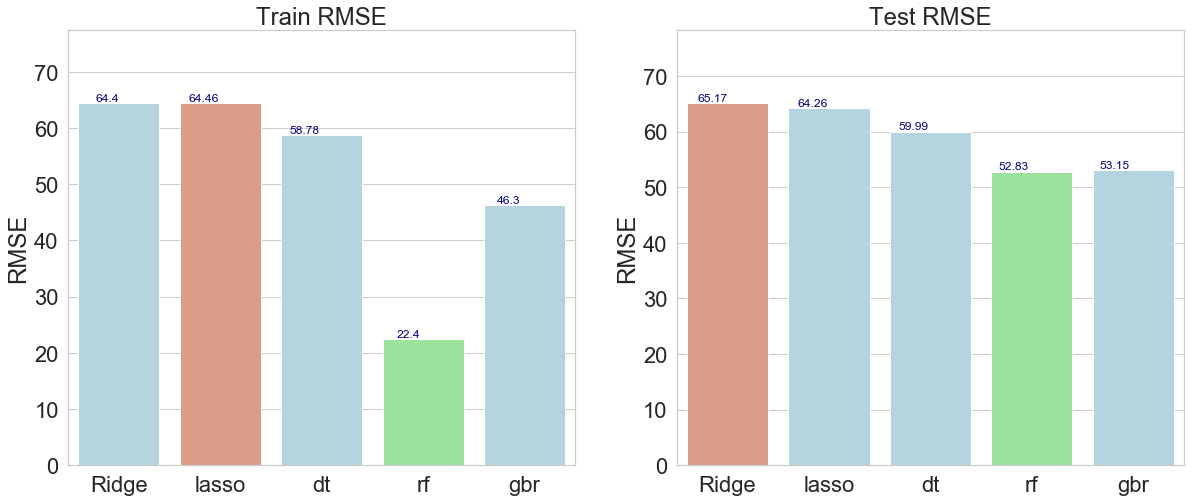

In [99]:
f, ax = plt.subplots(1,2,figsize=(20,8), sharey=False)
# g = sns.barplot(x="Regressor", y="Train RMSE", data=rmse_df, ax=ax[0])
# t = g.set(title="Train RMSE", ylabel="RMSE", xlabel="")
# g = sns.barplot(x="Regressor", y="Test RMSE", data=rmse_df, ax=ax[1])
# t = g.set(title="Test RMSE", ylabel="RMSE", xlabel="")

g = plot_bar(x="Regressor", y="Train RMSE", data=rmse_df, ax=ax[0], plot_mean=False, title="Train RMSE", ylabel="RMSE")
g = plot_bar(x="Regressor", y="Test RMSE", data=rmse_df, ax=ax[1], plot_mean=False, title="Test RMSE", ylabel="RMSE")


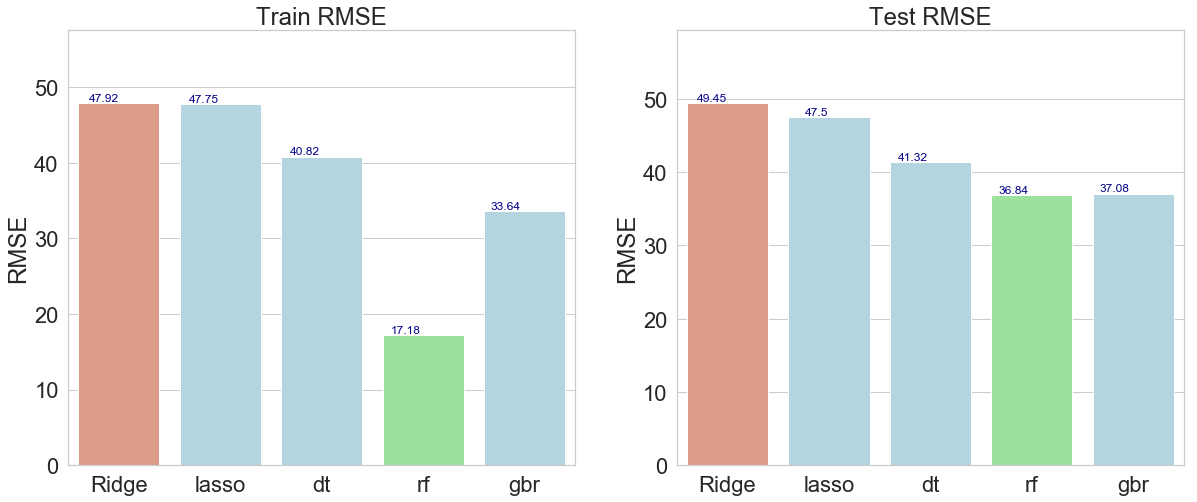

In [100]:
f, ax = plt.subplots(1,2,figsize=(20,8), sharey=False)
# g = sns.barplot(x="Regressor", y="Train RMSE", data=rmse_m_df, ax=ax[0])
# t = g.set(title="Train RMSE", ylabel="RMSE", xlabel="")
# g = sns.barplot(x="Regressor", y="Test RMSE", data=rmse_m_df, ax=ax[1])
# t = g.set(title="Test RMSE", ylabel="RMSE", xlabel="")

g = plot_bar(x="Regressor", y="Train RMSE", data=rmse_m_df, ax=ax[0], plot_mean=False, title="Train RMSE", ylabel="RMSE")
g = plot_bar(x="Regressor", y="Test RMSE", data=rmse_m_df, ax=ax[1], plot_mean=False, title="Test RMSE", ylabel="RMSE")

The overall RMSE values, and the general "fit" of the model onto the data has substantially improved. 

It can also be noted that the noise level increases significantly in later price bins, albiet lesser than before we used SMOTE to oversample values.The lower price bins are much more consistent with lesser noise than the higher ones.

Further exploration can be conducted to improve the fit of the regressors onto the dataset, and get lower RMSEs. 